### Cylindrical Epithelium 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import graph_tool.all as gt
import pandas as pd


In [2]:
### Typical number of vertices around the cylinder
n_circum = 24
### Typical number of vertices along z
n_length = 21
### Distance between 2 vertices
l_0 = 1. 
### heights
h_0 = 1.

/home/guillaume/anaconda/envs/python3/lib/python3.4/site-packages/matplotlib-1.4.x-py3.4-linux-x86_64.egg/matplotlib/figure.py:1644: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


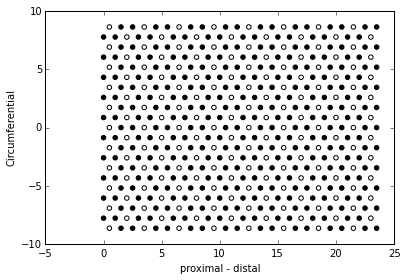

In [3]:

### Compute the cylinder radius from the number of vertices
rho_c = n_circum * l_0 / (2 * np.pi)
### Compute the lumen radius from the prefered height
rho_lumen = rho_c - h_0

delta_theta = 2 * np.pi / n_circum
delta_z = delta_theta * rho_c * np.sqrt(3)/2.

zt_grid = np.mgrid[:n_length, :n_circum]
thetas = zt_grid[1].astype('float')
thetas[::2, ...] += 0.5
is_cell_vert = np.zeros_like(zt_grid[1])
is_cell_vert[::2, ::3] = 1
is_cell_vert[1::2, 2::3] = 1

is_cell_vert = is_cell_vert.flatten()


zeds = zt_grid[0].astype('float')
pos = np.zeros((n_circum * n_length, 2))
pos[:, 0] = thetas.flatten()
pos[:, 1] = zeds.flatten()

pos = pd.DataFrame(pos, columns=['theta', 'z'])
#pos = pos.sort_index(by=['z', 'theta'])
pos.index = pd.Index(np.arange(n_circum * n_length), name='vertex')
pos.theta *= delta_theta

pos.z *= delta_z
pos.z -= pos.z.max() / 2


pos['x'] = np.cos(pos.theta) * rho_c
pos['y'] = np.sin(pos.theta) * rho_c




fig, ax = plt.subplots()
ax.scatter(pos.theta * rho_c, pos.z, c=is_cell_vert)
ax.set_aspect('equal')
ax.set_xlabel('proximal - distal')
ax.set_ylabel('Circumferential')

In [4]:
graph, pos_vp = gt.geometric_graph(pos[['x', 'y', 'z']], l_0*1.1)
graph.set_directed(True)
_icv = graph.new_vertex_property('bool')
_icv.a = is_cell_vert


In [5]:
is_je = graph.new_edge_property('bool')
is_je.a = 1
to_remove = []

for edge in graph.edges():
    srce, trgt = edge
    if _icv[srce] and not _icv[trgt]:
        is_je[edge] = 0
    elif not _icv[srce] and _icv[trgt]:
        ### Flip the edge
        to_remove.append(edge)
        new = graph.add_edge(trgt, srce)
        is_je[edge] = 0
    elif _icv[srce] and _icv[trgt]:
        raise ValueError('Invalid edge {}'.format(edge))
for edge in to_remove:
    graph.remove_edge(edge)

In [6]:
edges_idx = [(graph.vertex_index[srce], graph.vertex_index[trgt])
             for (srce, trgt) in graph.edges()]
edges_idx = pd.MultiIndex.from_tuples(edges_idx, names=('source', 'target'))
edges_df = pd.DataFrame(index=edges_idx)

In [23]:
dtype = pos.dtypes['x']

dtype.type

numpy.float64

In [26]:
is_cell_vert.dtype

dtype('int64')

TypeError: new_vertex_property() missing 1 required positional argument: 'value_type'

In [12]:
pos.dtypes['x']


dtype('float64')

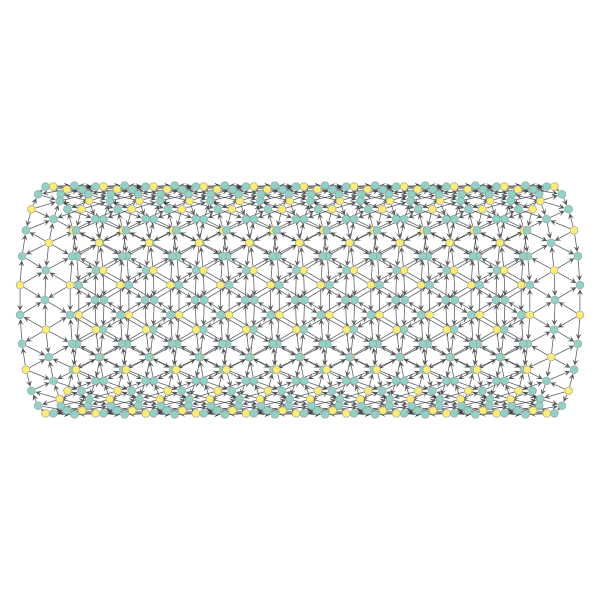

In [7]:
pos_vp = graph.new_vertex_property('vector<double>')
z_angle = np.pi/12
d_theta = 0

pos['pseudo_x'] = pos.z * np.cos(z_angle) - rho_c * np.sin(pos.theta + d_theta) * np.sin(z_angle)
pos['pseudo_y'] = rho_c * np.cos(pos.theta + d_theta)

pos_vp.set_2d_array(pos[['pseudo_x', 'pseudo_y']].values.T)
pseudo_pos = gt.graph_draw(graph, pos=pos_vp, vertex_fill_color=_icv, inline=True)

In [8]:
from leg_joint.epithelium import generation
gen_graph, vdf, edf = generation.cylindrical(n_cells_circum=n_circum//3,
                                             n_cells_length=n_length//3,
                                             l_0=1, h_0=1)
assert gt.isomorphism(graph, gen_graph)
assert np.all(pos.x == vdf.x)

ImportError: No module named 'leg_joint.epithelium.graph'

In [9]:
edf.is_junction_edge

source  target
0       23        1
        25        1
        24        1
        1         1
1       25        0
        2         0
2       27        1
3       28        0
        4         1
        27        0
        2         1
4       28        0
        5         0
5       30        0
6       31        0
...
495     496       0
        471       0
        472       0
        494       0
496     497       0
498     499       0
        474       0
        475       0
        497       0
499     500       0
501     502       0
        477       0
        478       0
        500       0
502     503       0
Name: is_junction_edge, Length: 1464, dtype: uint8